In [1]:
%matplotlib inline
from pylab import *
import matplotlib.pyplot as plt

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
gum.about()
gnb.configuration()


pyAgrum version 0.9.3.9
(c) Pierre-Henri Wuillemin, Christophe Gonzales, Lionel Torti
    UPMC 2015

    This is free software; see the source code for copying conditions.
    There is ABSOLUTELY NO WARRANTY; not even for MERCHANTABILITY or
    FITNESS FOR A PARTICULAR PURPOSE.  For details, see 'pyAgrum.warranty'.
    


Library,Version
OS,posix [linux]
Python,"3.5.2+ (default, Sep 22 2016, 12:18:14) [GCC 6.2.0 20160927]"
IPython,5.1.0
MatPlotLib,1.5.3
Numpy,1.11.2
pyAgrum,0.9.3.9


# Generating the database from a BN

In [3]:
bn=gum.loadBN("../resources/asia.bif")
bn

<pyAgrum.pyAgrum.BayesNet_double; proxy of <Swig Object of type 'gum::BayesNet< double > *' at 0x7f299dc1c420> >

In [4]:
# generateCSV from a BN : the loglikelihood of the base is returned
import pyAgrum.lib.bn2csv as bn2csv
bn2csv.generateCSV(bn,"sample_asia.csv",500000,True)

 sample_asia.csv : [ ######################################################### ] 100%
Log2-Likelihood : -1612252.0838279543



-1612252.0838279543

In [5]:
import pyAgrum.lib._utils.oslike as oslike
print("===\n  Size of the generated database\n===")
oslike.wc_l("sample_asia.csv")
print("\n===\n  First lines\n===")
oslike.head("sample_asia.csv")

===
  Size of the generated database
===
500001

===
  First lines
===
smoking?,lung_cancer?,bronchitis?,visit_to_Asia?,tuberculosis?,tuberculos_or_cancer?,dyspnoea?,positive_XraY?
0,0,1,1,1,0,0,0
0,1,0,1,1,1,0,1
0,1,0,1,1,1,1,1
0,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1
0,0,1,1,1,0,0,0
0,1,0,1,1,1,0,1
1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1



In [6]:
learner=gum.BNLearner("sample_asia.csv")
learner.names()

('smoking?',
 'lung_cancer?',
 'bronchitis?',
 'visit_to_Asia?',
 'tuberculosis?',
 'tuberculos_or_cancer?',
 'dyspnoea?',
 'positive_XraY?')

In [7]:
learner.idFromName('visit_to_Asia?') # first row is 0

3

In [8]:
learner.nameFromId(4)

'tuberculosis?'

# Parameters learning from the database

We give the $bn$ as a parameter for the learner in order to have the variables and the order of the labels for each variables. Please try to remove the argument $bn$ in the first line below to see the difference ...

In [9]:
learner=gum.BNLearner('sample_asia.csv',bn)
bn2=learner.learnParameters(bn)
gnb.showBN(bn2)

In [11]:
from IPython.display import HTML

HTML('<table><tr><td style="text-align:center;"><h3>original BN</h3></td>'+
     '<td style="text-align:center;"><h3>Learned BN</h3></td></tr>'+
     '<tr><td><center>'+
     gnb.getPotential(bn.cpt (bn.idFromName('visit_to_Asia?')))
     +'</center></td><td><center>'+
     gnb.getPotential(bn2.cpt(bn2.idFromName('visit_to_Asia?')))
     +'</center></td></tr><tr><td><center>'+
     gnb.getPotential(bn.cpt (bn.idFromName('tuberculosis?')))
     +'</center></td><td><center>'+
     gnb.getPotential(bn2.cpt(bn2.idFromName('tuberculosis?')))
     +'</center></td></tr></table>')

# Structural learning a BN from the database

## Different algorithms

For now, there are three algorithms that are wrapped in pyAgrum : LocalSearchWithTabuList,

In [20]:
learner=gum.BNLearner("sample_asia.csv")
learner.useLocalSearchWithTabuList()
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
gnb.showBN(bn2)
kl=gum.BruteForceKL(bn,bn2)
kl.compute()

Learned in 1921.030743ms


{'bhattacharya': 5.683714945375785,
 'errorPQ': 0,
 'errorQP': 128,
 'hellinger': 1.4118067182555931,
 'klPQ': 27.217431885822272,
 'klQP': 0.609484489677821}

A greedy Hill Climbing algorithm (with insert, remove and change arc as atomic operations).

In [21]:
learner=gum.BNLearner("sample_asia.csv")
learner.useGreedyHillClimbing()
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
bn2

Learned in 258.92989ms


<pyAgrum.pyAgrum.BayesNet_double; proxy of <Swig Object of type 'gum::BayesNet< double > *' at 0x7f299dc1cf90> >

And a K2 for those who likes it :)

In [22]:
learner=gum.BNLearner("sample_asia.csv")
learner.useK2([0,1,2,3,4,5,6,7])
bn2=learner.learnBN()
print("Learned in {0}ms".format(1000*learner.currentTime()))
bn2

Learned in 206.39318ms


<pyAgrum.pyAgrum.BayesNet_double; proxy of <Swig Object of type 'gum::BayesNet< double > *' at 0x7f299d8a6a80> >

K2 can be very good if the order is the good one (a topological order of nodes in the reference)


In [23]:
learner=gum.BNLearner("sample_asia.csv")
learner.useK2([7,6,5,4,3,2,1,0])
bn2=learner.learnBN()
print("Learned in {0}s".format(learner.currentTime()))
bn2

Learned in 0.244693401s


<pyAgrum.pyAgrum.BayesNet_double; proxy of <Swig Object of type 'gum::BayesNet< double > *' at 0x7f299dc1cfc0> >

# Following the learning curve

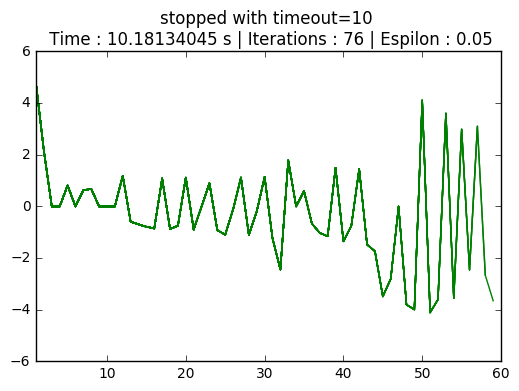

In [24]:
import numpy as np
%matplotlib inline

learner=gum.BNLearner("sample_asia.csv")
learner.useLocalSearchWithTabuList()

# we could prefere a log2likelihood score
# learner.useScoreLog2Likelihood()
learner.setMaxTime(10)

# representation of the error as a pseudo log (negative values really represents negative epsilon
@np.vectorize
def pseudolog(x):
    seuil=2.0
    y=-x if x<0 else x
        
    if y<seuil:
        res=y*np.log10(seuil)/seuil
    else:
        res=np.log10(y)
        
    return res if x>0 else -res

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(3) # no more than 1 parent by node
gnb.animApproximationScheme(learner,
                            scale=pseudolog) # scale by default is np.log10

bn2=learner.learnBN()


# Customizing the learning algorithms

## 1. Learn a tree ?

In [25]:
learner=gum.BNLearner("sample_asia.csv")
learner.useGreedyHillClimbing()

learner.setMaxIndegree(1) # no more than 1 parent by node

bn2=learner.learnBN()
bn2

<pyAgrum.pyAgrum.BayesNet_double; proxy of <Swig Object of type 'gum::BayesNet< double > *' at 0x7f29f01a9870> >

## 2. with prior structural knowledge

In [26]:
learner=gum.BNLearner("sample_asia.csv")
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc(0,1) # smoking->lung_cancer
learner.addMandatoryArc("visit_to_Asia?","tuberculosis?")

bn2=learner.learnBN()
gnb.showBN(bn2,size="5")
kl=gum.BruteForceKL(bn,bn2)
kl.compute()

{'bhattacharya': 5.666958090292313,
 'errorPQ': 0,
 'errorQP': 128,
 'hellinger': 1.4117660119883904,
 'klPQ': 24.046899398948803,
 'klQP': 0.6097105616425241}

## 3. changing the scores

By default, a BDEU score is used. But it can be changed.

In [38]:
learner=gum.BNLearner("sample_asia.csv")
learner.useGreedyHillClimbing()

# I know that smoking causes cancer
learner.addMandatoryArc(0,1)

# we prefere a log2likelihood score
learner.useScoreLog2Likelihood()

# in order to control the complexity, we limit the number of parents
learner.setMaxIndegree(1) # no more than 1 parent by node

bn2=learner.learnBN()
kl=gum.BruteForceKL(bn,bn2)
gnb.sideBySide(bn2,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

## 4. Mixing algorithms

First we learn a structure with HillClimbing (faster ?)

In [39]:
learner=gum.BNLearner("sample_asia.csv")
learner.useGreedyHillClimbing()
learner.addMandatoryArc(0,1)
bn2=learner.learnBN()
kl=gum.BruteForceKL(bn,bn2)
gnb.sideBySide(bn2,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

And then we refine with tabuList

In [40]:
learner=gum.BNLearner("sample_asia.csv")
learner.useLocalSearchWithTabuList()

learner.setInitialDAG(bn2.dag())
#learner.setMaxNbDecreasingChanges(2)

bn3=learner.learnBN()
kl=gum.BruteForceKL(bn,bn3)
gnb.sideBySide(bn3,
               "<br/>".join(["<b>"+k+"</b> :"+str(v) for k,v in kl.compute().items()]),
               captions=["learned BN","distances"])

# Impact of the size of the database for the learning

In [41]:
import IPython.display
rows=3
sizes=[400,500,700,1000,2000,5000,
       10000,50000,75000,
       100000,150000,175000,
       200000,300000,500000]

401
501
701
1001
2001
5001
10001
50001
75001
100001
150001
175001
200001
300001
500001


27.217438453723403


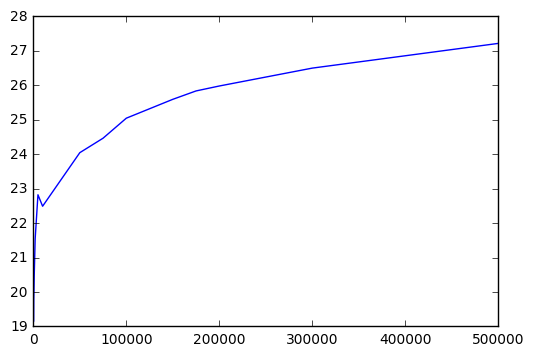

In [42]:
res="<table>"
nbr=0
l=[]
for i in sizes:
    n=i+1
    oslike.rm('extract_asia.csv')
    oslike.head('sample_asia.csv',n,'extract_asia.csv')
    oslike.wc_l('extract_asia.csv')
    learner=gum.BNLearner("extract_asia.csv")
    learner.useGreedyHillClimbing()
    bn2=learner.learnBN()
    
    kl=gum.BruteForceKL(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])
    
    if nbr % rows == 0:
        res+="<tr>"
    res+="<td><center>size="+str(i)+"</center>"+gnb.getBN(bn2,size="3",format="svg")+"</td>"
    nbr+=1
    if nbr % rows == 0:
        res+="</tr>"
if nbr % rows!=0:
    res+="</tr>"
res+="</table>"

IPython.display.display(IPython.display.HTML(res))

plot(sizes,l)
print(l[-1])

401
501
701
1001
2001
5001
10001
50001
75001
100001
150001
175001
200001
300001
500001


27.217431885822272


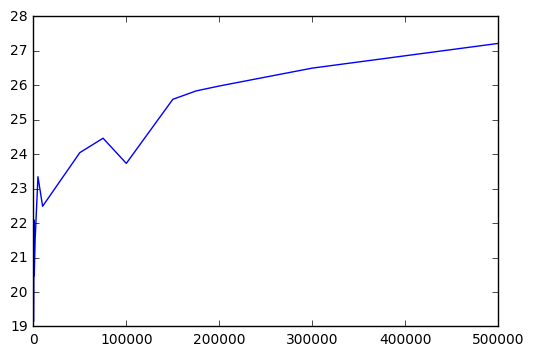

In [43]:
res="<table>"
nbr=0
l=[]
for i in sizes:
    n=i+1
    oslike.rm('extract_asia.csv')
    oslike.head('sample_asia.csv',n,'extract_asia.csv')
    oslike.wc_l('extract_asia.csv')
    learner=gum.BNLearner("extract_asia.csv")
    learner.useLocalSearchWithTabuList()
    bn2=learner.learnBN()
    
    kl=gum.BruteForceKL(bn,bn2)
    r=kl.compute()
    l.append(r['klPQ'])
    
    bn2.setProperty("name","BN(%{0})".format(i))
    if nbr % rows == 0:
        res+="<tr>"
    res+="<td><center>size="+str(i)+"</center>"+gnb.getBN(bn2,size="3",format="svg")+"</td>"
    nbr+=1
    if nbr % rows == 0:
        res+="</tr>"
if nbr % rows!=0:
    res+="</tr>"
res+="</table>"

IPython.display.display(IPython.display.HTML(res))

plot(sizes,l)
print(l[-1])